# BIO559R Example Notebook: Single-Cell Analysis with Python and R

This notebook demonstrates the basic workflow for single-cell RNA-seq analysis using both Python (scanpy) and R (Seurat/ggplot2) in a single Jupyter notebook.

**Author:** BIO559R Tutorial  
**Course:** Introduction to Systems Biology

## 1. Setup and Data Loading

First, let's import the necessary Python libraries and load the R magic extension.

In [1]:
# Import Python libraries
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure scanpy settings
sc.settings.verbosity = 3  # verbosity level
sc.settings.set_figure_params(dpi=80, facecolor='white')

print(f"Scanpy version: {sc.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

/Users/terooatt0/miniconda3/envs/bio559r/lib/python3.11/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


Scanpy version: 1.11.4
Pandas version: 2.3.2
NumPy version: 2.2.6


In [2]:
# Load R magic extension
%load_ext rpy2.ipython
print("R magic extension loaded successfully!")

R magic extension loaded successfully!


## 2. Create Synthetic Single-Cell Data

For this example, we'll create a synthetic single-cell dataset to demonstrate the analysis workflow.

In [3]:
# Create synthetic single-cell data
np.random.seed(42)

n_cells = 1000
n_genes = 2000

# Simulate count data with negative binomial distribution
X = np.random.negative_binomial(5, 0.3, (n_cells, n_genes))

# Create AnnData object
adata = sc.AnnData(X)

# Add gene and cell names
adata.var_names = [f'Gene_{i:04d}' for i in range(n_genes)]
adata.obs_names = [f'Cell_{i:04d}' for i in range(n_cells)]

# Add some metadata
adata.obs['batch'] = np.random.choice(['Batch_A', 'Batch_B'], n_cells)
adata.obs['cell_type'] = np.random.choice(['Type_1', 'Type_2', 'Type_3'], n_cells)

print(f"Created AnnData object with {adata.n_obs} cells and {adata.n_vars} genes")
print(adata)

Created AnnData object with 1000 cells and 2000 genes
AnnData object with n_obs × n_vars = 1000 × 2000
    obs: 'batch', 'cell_type'


## 3. Quality Control and Preprocessing with Scanpy

In [4]:
# Calculate QC metrics
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # mitochondrial genes
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

# Add number of genes per cell
adata.obs['n_genes'] = (adata.X > 0).sum(axis=1)

print("QC metrics calculated")
print(f"Mean genes per cell: {adata.obs['n_genes'].mean():.1f}")
print(f"Mean UMIs per cell: {adata.obs['total_counts'].mean():.1f}")

QC metrics calculated
Mean genes per cell: 1995.1
Mean UMIs per cell: 23328.7


In [5]:
# Preprocessing steps
print("Starting preprocessing...")

# Filter cells and genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Save raw data
adata.raw = adata

# Normalize to 10,000 reads per cell
sc.pp.normalize_total(adata, target_sum=1e4)

# Log transform
sc.pp.log1p(adata)

# Find highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Keep only highly variable genes
adata = adata[:, adata.var.highly_variable]

# Scale data
sc.pp.scale(adata, max_value=10)

print(f"After preprocessing: {adata.n_obs} cells, {adata.n_vars} highly variable genes")

Starting preprocessing...
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/Users/terooatt0/miniconda3/envs/bio559r/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


After preprocessing: 1000 cells, 617 highly variable genes


## 4. Dimensionality Reduction and Clustering

In [6]:
# Principal component analysis
sc.tl.pca(adata, svd_solver='arpack')

# Compute neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Perform UMAP embedding
sc.tl.umap(adata)

# Leiden clustering
sc.tl.leiden(adata, resolution=0.5)

print("Dimensionality reduction and clustering completed")
print(f"Number of clusters found: {len(adata.obs['leiden'].unique())}")

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40


/Users/terooatt0/miniconda3/envs/bio559r/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:00)
running Leiden clustering
    finished: found 1 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
Dimensionality reduction and clustering completed
Number of clusters found: 1


/var/folders/6y/1qbtc2814zd66fl_btj1dcp40000gr/T/ipykernel_57746/196643649.py:11: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


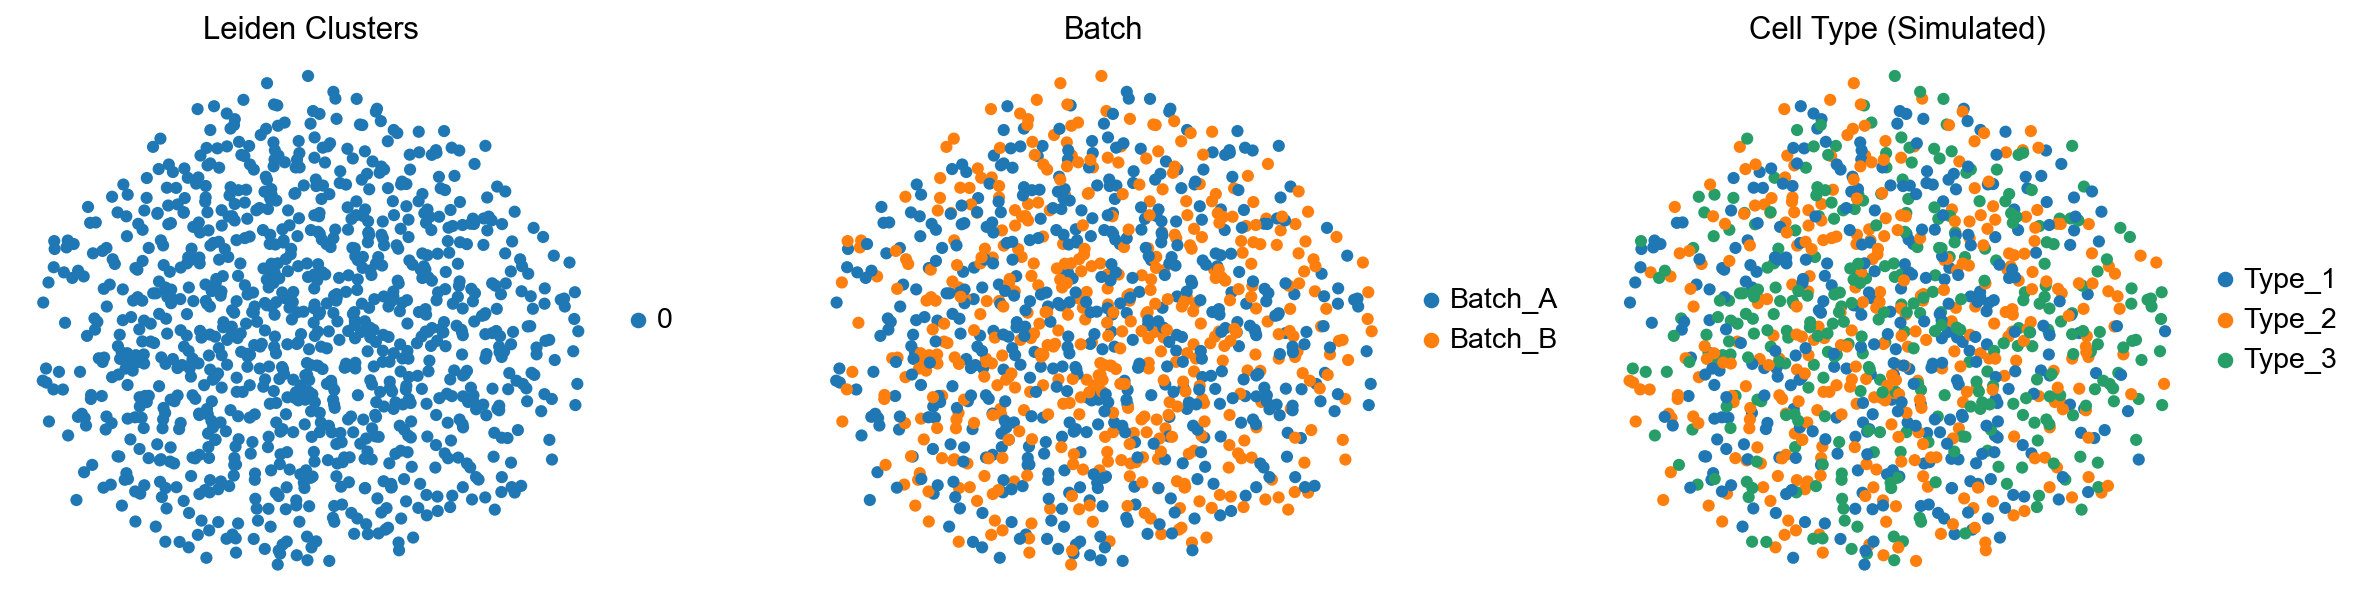

In [7]:
# Visualize results with scanpy
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sc.pl.umap(adata, color='leiden', ax=axes[0], show=False, frameon=False)
axes[0].set_title('Leiden Clusters')

sc.pl.umap(adata, color='batch', ax=axes[1], show=False, frameon=False)
axes[1].set_title('Batch')

sc.pl.umap(adata, color='cell_type', ax=axes[2], show=False, frameon=False)
axes[2].set_title('Cell Type (Simulated)')

plt.tight_layout()
plt.show()

## 5. Using R for Advanced Visualization

Now let's transfer our data to R and create publication-quality plots using ggplot2.

In [8]:
# Prepare data for R
umap_coords = adata.obsm['X_umap']
plot_df = pd.DataFrame({
    'UMAP1': umap_coords[:, 0],
    'UMAP2': umap_coords[:, 1],
    'leiden_cluster': adata.obs['leiden'].values,
    'batch': adata.obs['batch'].values,
    'cell_type': adata.obs['cell_type'].values,
    'n_genes': adata.obs['n_genes'].values
})

print(f"Prepared data frame with {len(plot_df)} cells for R visualization")
print(plot_df.head())

Prepared data frame with 1000 cells for R visualization
      UMAP1     UMAP2 leiden_cluster    batch cell_type  n_genes
0  6.331765  5.429115              0  Batch_B    Type_2     1992
1  4.823368  4.270721              0  Batch_B    Type_3     1995
2  2.337455  8.040139              0  Batch_B    Type_1     1993
3  2.562268  7.621429              0  Batch_B    Type_2     1996
4  3.774049  4.579515              0  Batch_B    Type_2     1997


In [9]:
%%R -i plot_df -w 12 -h 8

# Load required R libraries
library(ggplot2)
library(dplyr)

# Create a publication-quality UMAP plot
p1 <- ggplot(plot_df, aes(x = UMAP1, y = UMAP2, color = leiden_cluster)) +
    geom_point(size = 0.8, alpha = 0.7) +
    theme_classic() +
    theme(
        axis.text = element_text(size = 12),
        axis.title = element_text(size = 14),
        legend.title = element_text(size = 12),
        legend.text = element_text(size = 10),
        plot.title = element_text(size = 16, hjust = 0.5)
    ) +
    labs(
        title = "Single-Cell UMAP Visualization",
        x = "UMAP 1",
        y = "UMAP 2",
        color = "Leiden\nCluster"
    ) +
    guides(color = guide_legend(override.aes = list(size = 3)))

print(p1)

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [19]:
%%R
#install.packages(c("gridExtra","viridisLite","viridis"), repos="https://cloud.r-project.org")


NULL


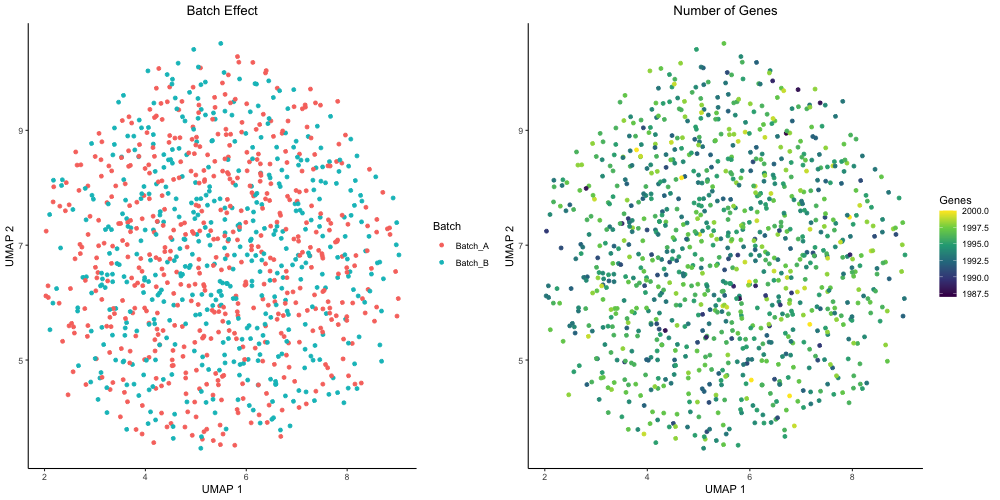

In [25]:
%%R -w 1000 -h 500

# Create a multi-panel plot
library(gridExtra)

# Plot by batch
p2 <- ggplot(plot_df, aes(x = UMAP1, y = UMAP2, color = batch)) +
    geom_point(size = 1.5, alpha = 1.5) +
    theme_classic() +
    labs(title = "Batch Effect", x = "UMAP 1", y = "UMAP 2", color = "Batch") +
    theme(plot.title = element_text(hjust = 0.5))

# Plot by number of genes
p3 <- ggplot(plot_df, aes(x = UMAP1, y = UMAP2, color = n_genes)) +
    geom_point(size = 1.5, alpha = 1.5) +
    scale_color_viridis_c() +
    theme_classic() +
    labs(title = "Number of Genes", x = "UMAP 1", y = "UMAP 2", color = "Genes") +
    theme(plot.title = element_text(hjust = 0.5))

# Combine plots
grid.arrange(p2, p3, ncol = 2)

## 6. Statistical Analysis with R

Let's perform some statistical analysis using R's powerful statistical functions.

In [26]:
%%R

# Ensure factor & drop unused levels (in case of prior filtering)
plot_df$leiden_cluster <- droplevels(factor(plot_df$leiden_cluster))

cat("Cluster counts:\n"); print(table(plot_df$leiden_cluster))

if (nlevels(plot_df$leiden_cluster) < 2) {
  message("ANOVA skipped: need ≥2 clusters; found ", nlevels(plot_df$leiden_cluster))
} else {
  anova_result <- aov(n_genes ~ leiden_cluster, data = plot_df)
  print(summary(anova_result))
}


Cluster counts:

   0 
1000 


R[write to console]: ANOVA skipped: need ≥2 clusters; found 1



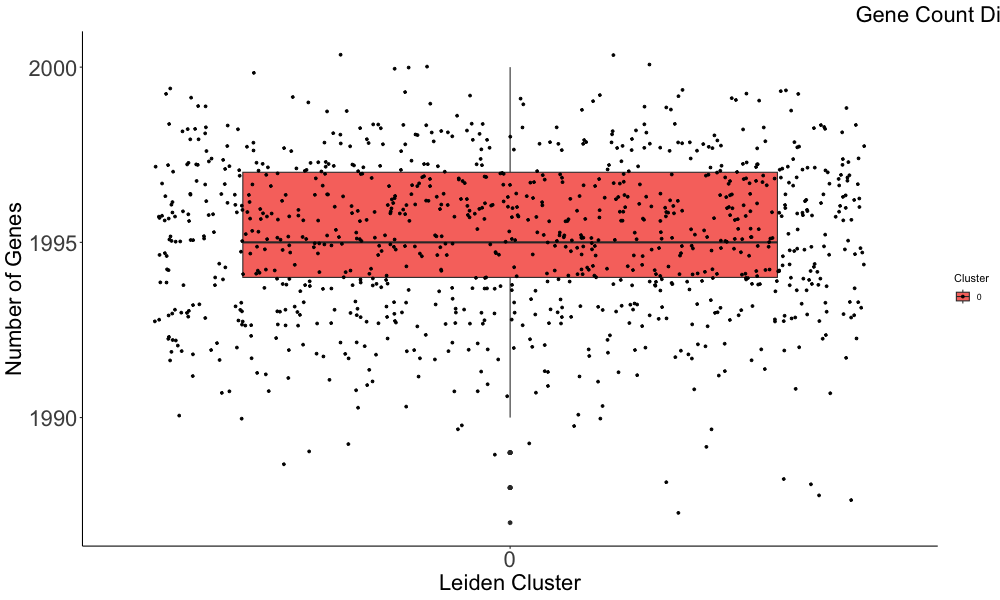

In [38]:
%%R -w 1000 -h 600

# Create a boxplot showing gene count distribution by cluster
p4 <- ggplot(plot_df, aes(x = leiden_cluster, y = n_genes, fill = leiden_cluster)) +
    geom_boxplot(alpha = 1.7) +
    geom_jitter(width = 0.5, alpha = 1, size = 1) +
    theme_classic() +
    labs(
        title = "Gene Count Distribution by Cluster",
        x = "Leiden Cluster",
        y = "Number of Genes",
        fill = "Cluster"
    ) +
    theme(
        plot.title = element_text(hjust = 1.5, size = 22),
        axis.text = element_text(size = 22),
        axis.title = element_text(size = 22)
    )

print(p4)

## 7. Transferring Results Back to Python

We can also transfer results from R back to Python for further analysis.

In [39]:
%%R -o cluster_stats_r

# This will transfer the cluster_stats data frame to Python
cluster_stats_r <- cluster_stats

In [40]:
# Now we can use the R results in Python
print("Cluster statistics transferred from R:")
print(cluster_stats_r)
print(f"\nData type: {type(cluster_stats_r)}")

# Convert to pandas DataFrame if needed
cluster_stats_pd = pd.DataFrame(cluster_stats_r)
print(f"\nAs pandas DataFrame:")
print(cluster_stats_pd)

Cluster statistics transferred from R:
  leiden_cluster  n_cells  mean_genes  sd_genes
1              0     1000    1995.099  2.199099

Data type: <class 'pandas.core.frame.DataFrame'>

As pandas DataFrame:
  leiden_cluster  n_cells  mean_genes  sd_genes
1              0     1000    1995.099  2.199099


## 8. Summary

This notebook demonstrated:

1. **Setting up the environment** with both Python and R packages
2. **Creating and preprocessing single-cell data** using scanpy
3. **Performing dimensionality reduction and clustering** with scanpy
4. **Creating publication-quality visualizations** with R and ggplot2
5. **Statistical analysis** using R's statistical functions
6. **Seamless data transfer** between Python and R environments

This workflow demonstrates the power of combining Python's computational efficiency (scanpy) with R's statistical and visualization capabilities (ggplot2, statistical tests) in a single analysis pipeline.

### Next Steps

- Try this workflow with real single-cell RNA-seq data
- Explore more advanced scanpy functions for trajectory analysis
- Learn about spatial transcriptomics analysis with squidpy
- Experiment with different R packages for specialized analyses